In [ ]:
#|default_exp centroid 

# Centroiding again

> But keeping time 

In the previous section we explained how to read the data contained in the Thermo `.RAW` file into dataframes and explore them in an interactive plot. At the highest resolution it became clear that the individual data points during the three minutes scan scatter around the vertical gray lines located at the maxima of their corresponding peaks in the time integrated mass histogram shown in the lower part of the figure. Reason for this scattering is the limited instrumental precision of the mass spectrometer. In order to proceed with our analysis we essentially need to horizontally move all points that are located within the instrumental precision onto these vertical gray lines. Confusingly the raw data was already centroided within each individual scan during the measurement. And now by horizontally shifting the masses to these histogram maxima we centroid the data again!     

In [ ]:
from kendrick import histogram, get_time_averaged_centroids, interactive_plot, read_raw, centralize

In [ ]:
raw_file = '/home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Joana_100-24-1_01.RAW'

In [ ]:
df_pos, df_neg = read_raw(raw_file)

mz_hist = histogram(df_pos)
mz_centroids = get_time_averaged_centroids(mz_hist)

To create a new dataframe with mass points that are aligned to the centroid lines use the `centralize()` function. 

In [ ]:
df_centr = centralize(df_pos, mz_centroids)

Let's now inspect this centroided dataframe in interactive plot below. 

In [ ]:
%matplotlib widget

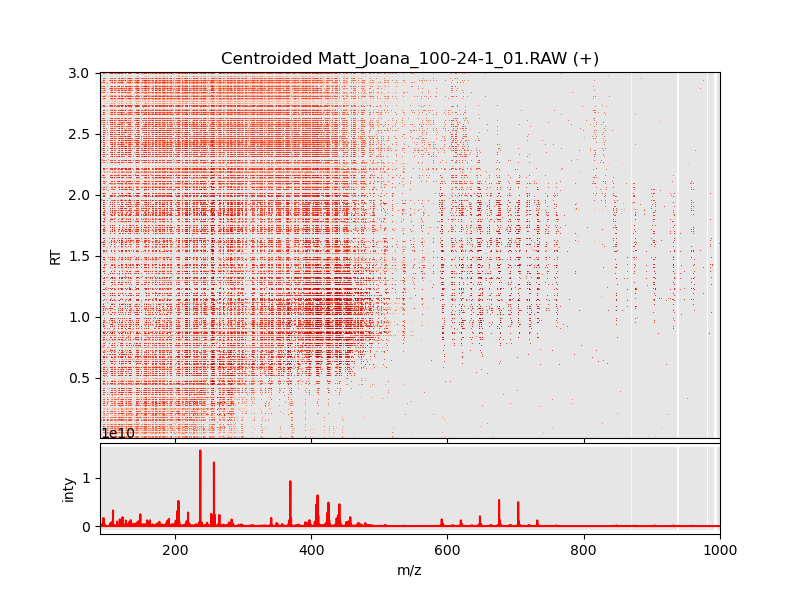

In [ ]:
interactive_plot(df_centr, mz_hist, mz_centroids, title='Centroided Matt_Joana_100-24-1_01.RAW (+)')

At low resolution this plot looks quite similar to the original data. However, when zooming in one can observe that the mass points are now perfectly aligned with the grey centroid lines. By doing so we have increased the mass resolution of our data which means that we are ready to create Kendrick plots in the next section! 

## FUNCTIONS 

In [ ]:
#|export 

from dask import array as da 

In [ ]:
#|export  

def centralize(df, mz_centroids, precision=0.002):
    '''Shift mass points to centroid positions. 
    
    Keep retention time dimension.'''
    
    # extract numpy arrays from dataframe and centroids array 
    mz = df['mz'].values 
    mzc = mz_centroids[:,0] 
    
    # for efficient computation convert to dask arrays 
    mz_arr = da.from_array(mz)
    mzc_arr = da.from_array(mzc)
    
    # create distances table 
    diff_arr = ((mz_arr[:, None] - mzc_arr[None, :])**2)**0.5
    
    # compute nearest distance for each mass point 
    distances = diff_arr.min(axis=1).compute()
    
    # within precision 
    is_nearby = distances < precision
    
    # locate corresponding centroid mass indexes 
    nearest_idxs = list(diff_arr.argmin(axis=1).compute())
    
    # replace mz column in dataframe with centroid mz 
    df_centr = df.copy()
    df_centr['mz'] = mzc[nearest_idxs]
    
    # discard outliers
    df_centr = df_centr[is_nearby]

    return df_centr